In [1]:
from matplotlib import pyplot as plt
import numpy as np
from utilities import load

import keras

from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import merge,Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, Dense, Conv2D, MaxPooling2D,Conv2DTranspose, \
    UpSampling2D, Activation, LeakyReLU, Flatten, Dropout, GaussianNoise
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
from keras.utils import np_utils

import tensorflow

import sklearn
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import pickle
import os

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load data

In [2]:

dataa, lb = load()

data = np.array(dataa)

data = data.reshape(-1, 120,120, 1)
labels = np.array(lb)


Reading file  output_im_3.p ...
Reading file  output_im_2.p ...
Reading file  output_im_0.p ...
Reading file  output_lb.p ...
Reading file  output_im_1.p ...
Reading file  output_im_5.p ...
Reading file  output_im_4.p ...
Reading file  output_im_6.p ...
Reading file  output_im_7.p ...


In [3]:
print(data.shape)
print(labels.shape)

(40000, 120, 120, 1)
(40000,)


In [5]:
# data = data[:20000,:,:,:]
# labels = labels[:20000]
print(data.shape)
data, labels = shuffle(data, labels, random_state=0)

(40000, 120, 120, 1)


In [6]:
# train_data = data[0:16000,:,:,:]
# train_labels = labels[0:16000]

# val_data = data[16000:18000,:,:,:]
# val_labels = labels[16000:18000]

# test_data = data[18000:20000,:,:,:]
# test_labels = labels[18000:20000]

# train_data = data[0:8000,:,:,:]
# train_labels = labels[0:8000]

# val_data = data[8000:9000,:,:,:]
# val_labels = labels[8000:9000]

# test_data = data[9000:10000,:,:,:]
# test_labels = labels[9000:10000]


train_data = data[0:32000,:,:,:]
train_labels = labels[0:32000]

val_data = data[32000:36000,:,:,:]
val_labels = labels[32000:36000]

test_data = data[36000:,:,:,:]
test_labels = labels[36000:]

In [7]:
len(test_data)

4000

In [8]:
print(train_data.shape)
print(test_data.shape)

(32000, 120, 120, 1)
(4000, 120, 120, 1)


In [9]:
print(train_labels.shape)
print(val_labels.shape)

(32000,)
(4000,)


### Preprocess

In [10]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(train_labels)
encoded_labels = encoder.transform(train_labels)
train_labels_onehot = np_utils.to_categorical(encoded_labels)

encoder.fit(val_labels)
encoded_labels = encoder.transform(val_labels)
val_labels_onehot = np_utils.to_categorical(encoded_labels)

encoder.fit(test_labels)
encoded_labels = encoder.transform(test_labels)
test_labels_onehot = np_utils.to_categorical(encoded_labels)


### Architecture

In [11]:
def CNN():
    input_img = Input(shape=(120, 120, 1))
    x = Conv2D(128, (3, 3), activation='relu', padding='same', dilation_rate=(2,2))(input_img)
    x = GaussianNoise(0.002)(x)
    x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.3)(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same', dilation_rate=(2,2))(x)
    x = GaussianNoise(0.002)(x)
    x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.3)(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same', dilation_rate=(2,2))(x)
#    x = GaussianNoise(0.001)(x)
    x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.3)(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
  #  x = GaussianNoise(0.002)(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)
    return Model(input_img, output)


batch_size = 64
epochs = 10
num_classes = 10


#MOST DATA VALUES ARE 0.01 


#0.01 first layer, 0.005 b4 Dropout ===> 0.09
#0.005 first layer ===> 0.912


In [12]:
CNN = CNN()
CNN.compile(loss='categorical_crossentropy',  optimizer = RMSprop(), metrics=['accuracy'])


In [13]:
CNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 120, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 128)     1280      
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 120, 120, 128)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 120, 120, 128)     512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        73792     
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 60, 60, 64)        0         
__________

### Train

In [14]:
CNN_train = CNN.fit(train_data, train_labels_onehot, batch_size=batch_size,epochs=epochs,\
                                    verbose=1,validation_data=(val_data, val_labels_onehot))

Train on 32000 samples, validate on 4000 samples
Epoch 1/10
32000/32000 [==============================] - 71s 2ms/step - loss: 0.4399 - acc: 0.8818 - val_loss: 0.0128 - val_acc: 0.9980
Epoch 2/10
32000/32000 [==============================] - 68s 2ms/step - loss: 0.0566 - acc: 0.9844 - val_loss: 0.0052 - val_acc: 0.9985
Epoch 3/10
32000/32000 [==============================] - 68s 2ms/step - loss: 0.0355 - acc: 0.9919 - val_loss: 0.0035 - val_acc: 0.9995
Epoch 4/10
32000/32000 [==============================] - 68s 2ms/step - loss: 0.0267 - acc: 0.9933 - val_loss: 0.0026 - val_acc: 0.9998
Epoch 5/10
32000/32000 [==============================] - 68s 2ms/step - loss: 0.0233 - acc: 0.9943 - val_loss: 0.0076 - val_acc: 0.9990
Epoch 6/10
32000/32000 [==============================] - 68s 2ms/step - loss: 0.0153 - acc: 0.9963 - val_loss: 0.0534 - val_acc: 0.9922
Epoch 7/10
32000/32000 [==============================] - 68s 2ms/step - loss: 0.0210 - acc: 0.9962 - val_loss: 0.3377 - val_acc:

In [15]:
CNN.save('my_CNN.h5')

### Results

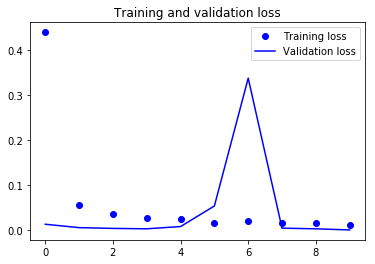

In [16]:
loss = CNN_train.history['loss']
val_loss = CNN_train.history['val_loss']
epochs = range(10)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Predict and Evaluate on Test set

In [17]:
print(test_labels_onehot.shape)
print(len(test_data))

(4000, 10)
4000


In [18]:
loss, acc = CNN.evaluate(test_data, test_labels_onehot, batch_size=batch_size, verbose=0)

In [19]:
print('Test loss:', loss)
print('Test accuracy:', acc)

Test loss: 0.002794500764627742
Test accuracy: 0.9995


In [20]:
predicted_classes = CNN.predict(test_data)

In [21]:
print(predicted_classes.shape)
predicted = predicted_classes.argmax(axis=1)

(4000, 10)


In [22]:
print("predicted:", predicted)
predicted.shape
#print("ground truth:",(test_labels).astype(int).T[0])

predicted: [3 1 4 ... 5 0 5]


(4000,)

In [23]:
correct = np.where(predicted==test_labels)[0]
print(len(correct))

3998


Found 3998 correct labels


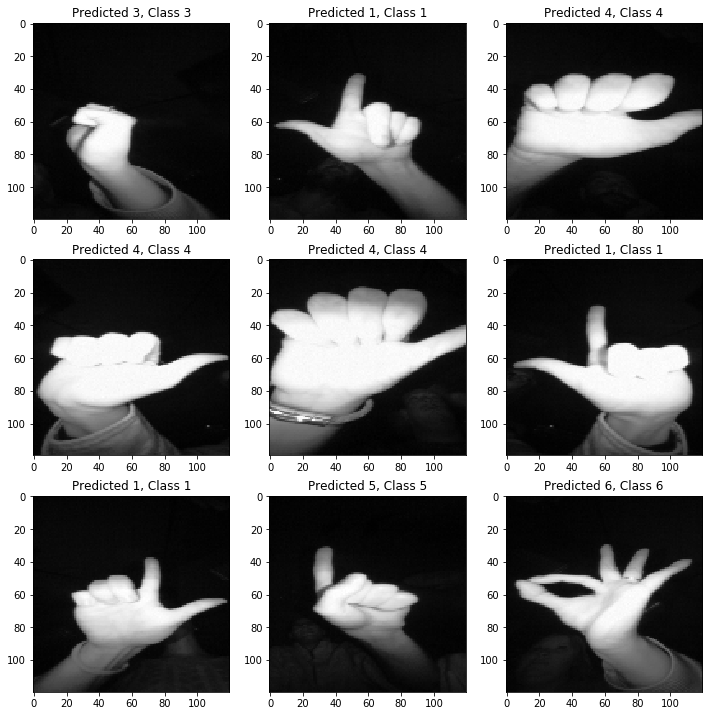

In [24]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes.shape, test_labels_onehot.shape

print('Found %d correct labels' %len(correct))
fig = plt.figure(figsize=(10, 10))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[correct].reshape(120,120), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_labels[correct]))
    plt.tight_layout()

Found 2 incorrect labels


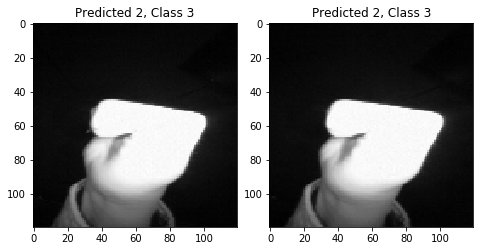

In [25]:
incorrect = np.where(predicted_classes!=test_labels)[0]
print('Found %d incorrect labels' % len(incorrect))
fig = plt.figure(figsize=(10, 10))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[incorrect].reshape(120,120), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_labels[incorrect]))
    plt.tight_layout()

In [26]:
confusion_matrix = metrics.confusion_matrix(y_true=test_labels, y_pred=predicted_classes)  # shape=(12, 12)

Text(0.5,1,'Normalized Confusion Matrix')

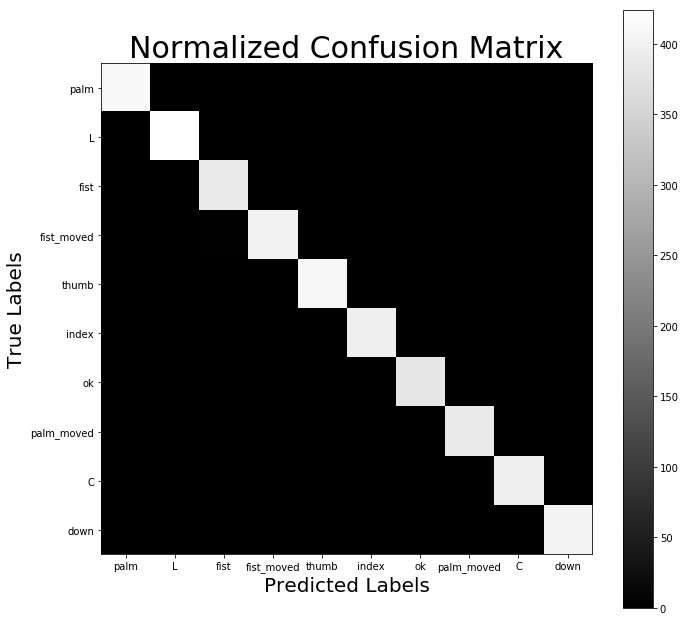

In [27]:
# classes = { 'palm'       : 0,
#             'l'          : 1,
#             'fist'       : 2,
#             'fist_moved' : 3,
#             'thumb'      : 4,
#             'index'      : 5,
#             'ok'         : 6,
#             'palm_moved' : 7,
#             'c'          : 8,
#             'down'       : 9
#               }
classes = {0: 'palm',
           1: 'L',  
           2: 'fist',     
           3: 'fist_moved', 
           4: 'thumb',      
           5: 'index',     
           6: 'ok',        
           7: 'palm_moved', 
           8: 'C',         
           9: 'down'  
              }
fig = plt.figure(figsize=(11, 11))
plt.imshow(confusion_matrix, cmap='gray')
plt.xticks(np.arange(10), list(classes.values()))
plt.xlabel("Predicted Labels", fontsize=20)
plt.yticks(np.arange(10), list(classes.values()))
plt.ylabel("True Labels", fontsize=20)
plt.colorbar()
plt.title("Normalized Confusion Matrix", fontsize=30)

### Classification Report

In [28]:
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_labels, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       414
     Class 1       1.00      1.00      1.00       424
     Class 2       0.99      1.00      1.00       387
     Class 3       1.00      1.00      1.00       403
     Class 4       1.00      1.00      1.00       409
     Class 5       1.00      1.00      1.00       396
     Class 6       1.00      1.00      1.00       381
     Class 7       1.00      1.00      1.00       388
     Class 8       1.00      1.00      1.00       395
     Class 9       1.00      1.00      1.00       403

   micro avg       1.00      1.00      1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000

